### RandomForest, XGBoost 시계열 예측(Regressor)
- TRAIN DATA SET: 2014년~2021년

- TEST DATA SET: 2022년, 2023년  

In [1]:
import pandas as pd
import numpy as np
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [3]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


###  MODELING

In [4]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [5]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

49


In [6]:
# 학습 데이터와 테스트 데이터로 분할
train_df = df_raw[(df_raw['create_date'] >= '2014-01-01') & (df_raw['create_date'] <= '2021-12-31')]
test_df = df_raw[(df_raw['create_date'] >= '2022-01-01') & (df_raw['create_date'] <= '2023-12-31')]

# 테스트 데이터 연도별 분할
test_df_2022 = test_df[test_df['create_date'].dt.year == 2022]
test_df_2023 = test_df[test_df['create_date'].dt.year == 2023]

In [7]:
print(len(train_df))
print(len(test_df))
print(len(test_df)/len(train_df))

20808
5202
0.25


In [8]:
# 특징과 목표 변수 분리
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# create_date 값을 저장
create_date_test = test_df['create_date']

X_test_2022 = test_df_2022[features]
y_test_2022 = test_df_2022[target]

X_test_2023 = test_df_2023[features]
y_test_2023 = test_df_2023[target]

# create_date 값을 저장
create_date_test_2022 = test_df_2022['create_date']
create_date_test_2023 = test_df_2023['create_date']

In [9]:
print('학습데이터 샘플 개수:', len(X_train))
print('학습데이터 샘플 개수:', len(X_test))

학습데이터 샘플 개수: 20808
학습데이터 샘플 개수: 5202


In [10]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_2022 = scaler.transform(X_test_2022)
X_test_2023 = scaler.transform(X_test_2023)

### RandomForest

In [11]:
# RandomForest 모델 정의 및 학습
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# 예측
y_pred_test_rf_2022 = rf_model.predict(X_test_2022)
y_pred_test_rf_2023 = rf_model.predict(X_test_2023)

# 평가
mae_test_rf_2022 = mean_absolute_error(y_test_2022, y_pred_test_rf_2022)
mse_test_rf_2022 = mean_squared_error(y_test_2022, y_pred_test_rf_2022)
r2_test_rf_2022 = r2_score(y_test_2022, y_pred_test_rf_2022)

mae_test_rf_2023 = mean_absolute_error(y_test_2023, y_pred_test_rf_2023)
mse_test_rf_2023 = mean_squared_error(y_test_2023, y_pred_test_rf_2023)
r2_test_rf_2023 = r2_score(y_test_2023, y_pred_test_rf_2023)

In [12]:
print("Random Forest Regressor 2022:")
print(f'Test MAE: {mae_test_rf_2022}')
print(f'Test MSE: {mse_test_rf_2022}')
print(f'Test R2: {r2_test_rf_2022}')
print()
print("Random Forest Regressor 2023:")
print(f'Test MAE: {mae_test_rf_2023}')
print(f'Test MSE: {mse_test_rf_2023}')
print(f'Test R2: {r2_test_rf_2023}')

Random Forest Regressor 2022:
Test MAE: 0.5948673587081892
Test MSE: 1.7066861591695501
Test R2: 0.446328663488456

Random Forest Regressor 2023:
Test MAE: 0.7363898500576701
Test MSE: 3.2633826605151866
Test R2: 0.5959778954093851


### XGBoost

In [13]:
# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# 예측
y_pred_test_xgb_2022 = xgb_model.predict(X_test_2022)
y_pred_test_xgb_2023 = xgb_model.predict(X_test_2023)

# 평가
mae_test_xgb_2022 = mean_absolute_error(y_test_2022, y_pred_test_xgb_2022)
mse_test_xgb_2022 = mean_squared_error(y_test_2022, y_pred_test_xgb_2022)
r2_test_xgb_2022 = r2_score(y_test_2022, y_pred_test_xgb_2022)

mae_test_xgb_2023 = mean_absolute_error(y_test_2023, y_pred_test_xgb_2023)
mse_test_xgb_2023 = mean_squared_error(y_test_2023, y_pred_test_xgb_2023)
r2_test_xgb_2023 = r2_score(y_test_2023, y_pred_test_xgb_2023)

In [14]:
print("XGBoost Regressor 2022:")
print(f'Test MAE: {mae_test_xgb_2022}')
print(f'Test MSE: {mse_test_xgb_2022}')
print(f'Test R2: {r2_test_xgb_2022}')
print()
print("XGBoost Regressor 2023:")
print(f'Test MAE: {mae_test_xgb_2023}')
print(f'Test MSE: {mse_test_xgb_2023}')
print(f'Test R2: {r2_test_xgb_2023}')

XGBoost Regressor 2022:
Test MAE: 0.607740222703144
Test MSE: 1.9087173356029885
Test R2: 0.3807871045604042

XGBoost Regressor 2023:
Test MAE: 0.7673915058547797
Test MSE: 3.6347036066351768
Test R2: 0.5500066178313234


In [18]:
# 성능 평가 결과를 데이터프레임으로 정리
results = [
    {'Model': 'RandomForest', 'Year': 2022, 'MAE': mae_test_rf_2022, 'MSE': mse_test_rf_2022, 'R2': r2_test_rf_2022},
    {'Model': 'RandomForest', 'Year': 2023, 'MAE': mae_test_rf_2023, 'MSE': mse_test_rf_2023, 'R2': r2_test_rf_2023},
    {'Model': 'XGBoost', 'Year': 2022, 'MAE': mae_test_xgb_2022, 'MSE': mse_test_xgb_2022, 'R2': r2_test_xgb_2022},
    {'Model': 'XGBoost', 'Year': 2023, 'MAE': mae_test_xgb_2023, 'MSE': mse_test_xgb_2023, 'R2': r2_test_xgb_2023}
]

df_results = pd.DataFrame(results)
print(df_results)

          Model  Year       MAE       MSE        R2
0  RandomForest  2022  0.594867  1.706686  0.446329
1  RandomForest  2023  0.736390  3.263383  0.595978
2       XGBoost  2022  0.607740  1.908717  0.380787
3       XGBoost  2023  0.767392  3.634704  0.550007


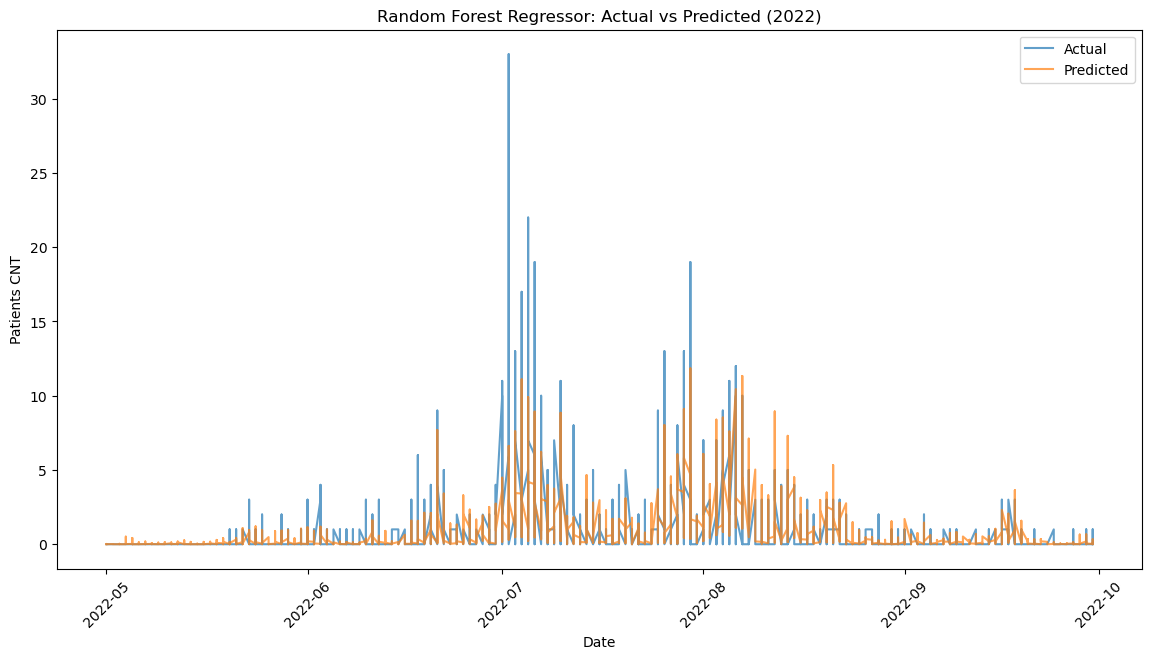

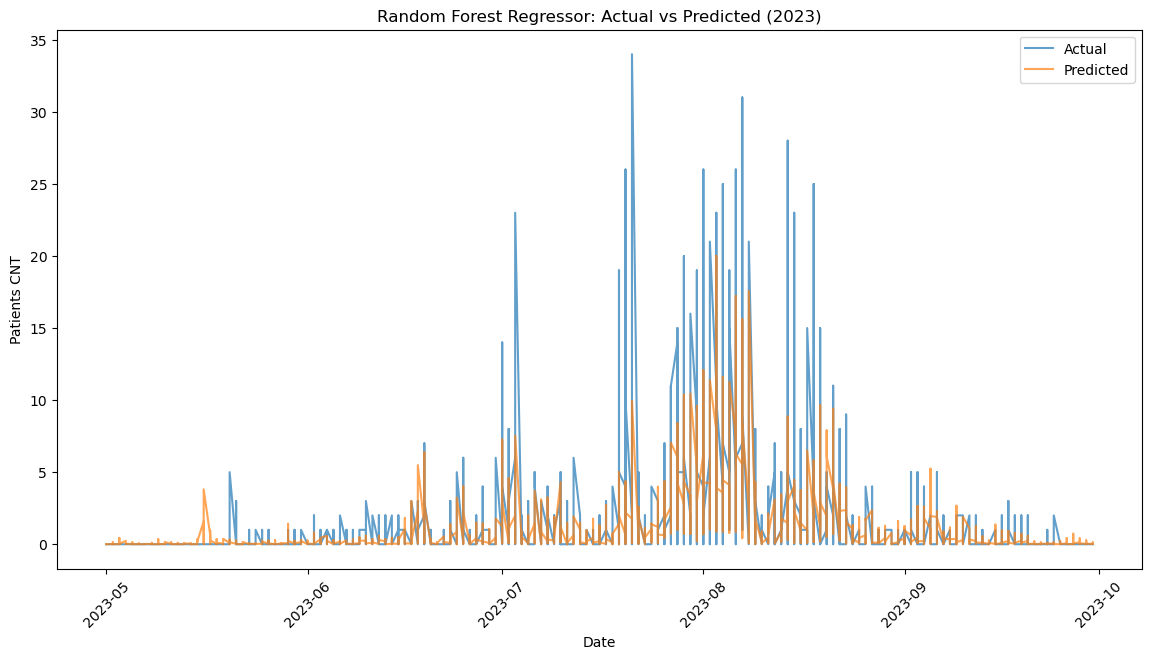

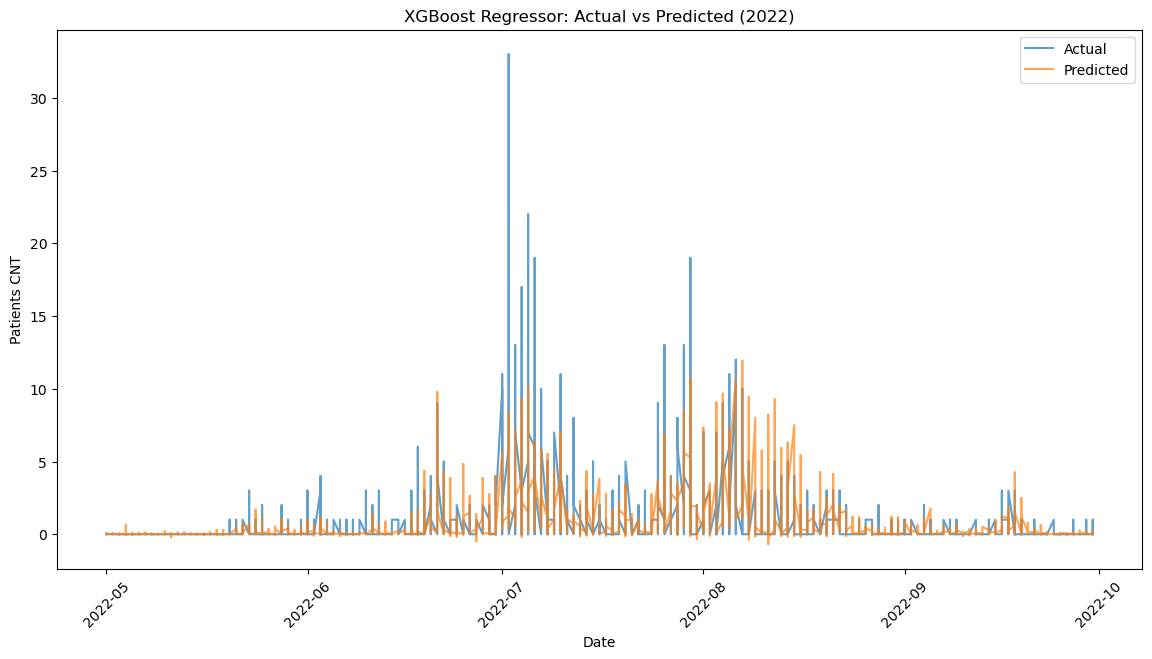

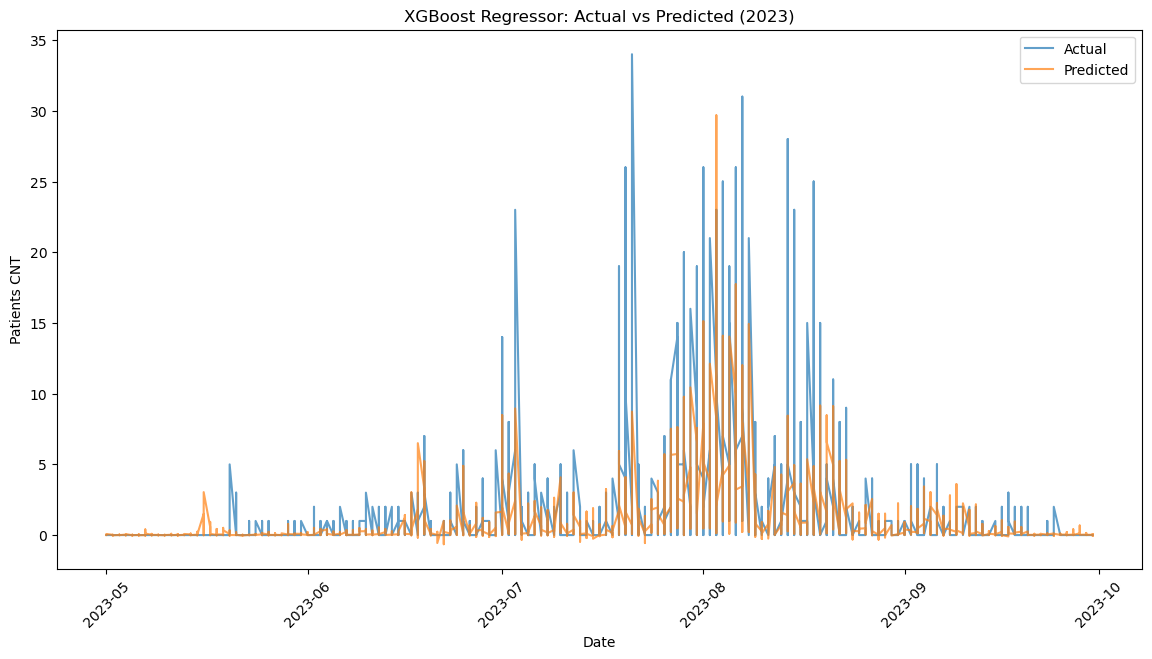

In [19]:
# 시각화 함수 정의
def plot_predictions(y_true, y_pred, dates, title):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true, label='Actual', alpha=0.7)
    plt.plot(dates, y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Patients CNT')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# RandomForest 예측값 시각화
plot_predictions(y_test_2022, y_pred_test_rf_2022, create_date_test_2022, 'Random Forest Regressor: Actual vs Predicted (2022)')
plot_predictions(y_test_2023, y_pred_test_rf_2023, create_date_test_2023, 'Random Forest Regressor: Actual vs Predicted (2023)')

# XGBoost 예측값 시각화
plot_predictions(y_test_2022, y_pred_test_xgb_2022, create_date_test_2022, 'XGBoost Regressor: Actual vs Predicted (2022)')
plot_predictions(y_test_2023, y_pred_test_xgb_2023, create_date_test_2023, 'XGBoost Regressor: Actual vs Predicted (2023)')